### Multimodal Classification: text + tabular + image
### Early fusion NN + Feature fusion with XGBoost and SVM

In [193]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, 
    Dense, Dropout, Concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.preprocessing import image as keras_image
import matplotlib.pyplot as plt

In [3]:
"""my plan is to first perform early fusion between the tabular features and the
 text data (using tokenized text as input). This combined representation will be fed 
 into a suitable neural network. In parallel, the image data will be processed using a 
 pretrained neural network to extract visual features. Finally, I will apply feature-level 
 fusion between the learned representations from the text–tabular model and the image model, and use the 
 fused features as input to XGBoost and SVM classifiers for final prediction."""

'my plan is to first perform early fusion between the tabular features and the\n text data (using tokenized text as input). This combined representation will be fed \n into a suitable neural network. In parallel, the image data will be processed using a \n pretrained neural network to extract visual features. Finally, I will apply feature-level \n fusion between the learned representations from the text–tabular model and the image model, and use the \n fused features as input to XGBoost and SVM classifiers for final prediction.'

In [158]:
df = pd.read_csv("FoodFactsCleaned.csv")

In [159]:
TEXT_COLS = [
    "brand_cleaned",
    "allergens_cleaned",
    "ingredients_text_cleaned",
    "countries_cleaned",
    "additives_cleaned",
]

TABULAR_COLS = [
    'nova_group', 'fat_100g',
    'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
    'proteins_100g', 'contains_palm_oil', 'vegetarian_status', 'vegan_status',
    'nutrient_level_fat', 'nutrient_level_saturated_fat',
    'nutrient_level_sugars', 'nutrient_level_salt', 'ecoscore_grade', 'ecoscore_score',
    'carbon_footprint_100g', 'additives_count', 'sugar_ratio',
    'energy_density', 'protein_ratio', 'macro_balance', 'healthy_score',
    'log_energy_kcal_100g', 'log_salt_100g'
]

TARGET_COL = "nutriscore_letter"         
IMAGE_PATH_COL = "image_160_path"  
RANDOM_STATE = 42
TEST_SIZE = 0.2


MAX_WORDS = 30000
MAX_LEN = 400

In [160]:
for c in TEXT_COLS:
    df[c] = df[c].fillna("").astype(str)

df["text_concat"] = df[TEXT_COLS].agg(" ".join, axis=1)

print("Rows after image path filtering:", len(df))

Rows after image path filtering: 5138


In [161]:
X_text = df["text_concat"].values
X_tab = df[TABULAR_COLS].values
X_img_paths = df[IMAGE_PATH_COL].astype(str).values
y = df[TARGET_COL].values



X_text_tv, X_text_te, X_tab_tv, X_tab_te, X_img_tv, X_img_te, y_tv, y_te = train_test_split(
    X_text, X_tab, X_img_paths, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

X_text_tr, X_text_val, X_tab_tr, X_tab_val, X_img_tr, X_img_val, y_tr, y_val = train_test_split(
    X_text_tv, X_tab_tv, X_img_tv, y_tv,
    test_size=0.25,  
    random_state=RANDOM_STATE,
    stratify=y_tv
)

num_classes = len(np.unique(y))
print("Train:", len(y_tr), "val:", len(y_val), "Test:", len(y_te), "Classes:", num_classes)

Train: 3082 val: 1028 Test: 1028 Classes: 5


In [162]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text_tr)

seq_tr  = tokenizer.texts_to_sequences(X_text_tr)
seq_val = tokenizer.texts_to_sequences(X_text_val)
seq_te  = tokenizer.texts_to_sequences(X_text_te)

X_text_tr_pad = pad_sequences(
    seq_tr, maxlen=MAX_LEN, padding="post", truncating="post"
)

X_text_val_pad = pad_sequences(
    seq_val, maxlen=MAX_LEN, padding="post", truncating="post"
)

X_text_te_pad = pad_sequences(
    seq_te, maxlen=MAX_LEN, padding="post", truncating="post"
)

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)

scaler = StandardScaler()
X_tab_tr_scaled = scaler.fit_transform(X_tab_tr)
X_tab_val_scaled = scaler.transform(X_tab_val)
X_tab_te_scaled = scaler.transform(X_tab_te)

In [163]:
def build_text_tab_model(vocab_size, max_len, tab_dim, num_classes):
    # Text branch
    text_in = Input(shape=(max_len,), name="text_in")
    x_text = Embedding(input_dim=vocab_size, output_dim=256, input_length=max_len)(text_in)
    x_text = GlobalAveragePooling1D()(x_text)
    x_text = Dropout(0.4)(x_text)

    # Tabular branch
    tab_in = Input(shape=(tab_dim,), name="tab_in")
    x_tab = Dense(128, activation="relu")(tab_in)
    x_tab = Dropout(0.3)(x_tab)
    x_tab = Dense(64, activation="relu")(x_tab)
    x_tab = Dense(32, activation="relu")(x_tab)
    x_tab = Dropout(0.2)(x_tab)
    # Early fusion
    fused = Concatenate()([x_text, x_tab])
    fused = Dense(128, activation="relu")(fused)
    fused = Dropout(0.3)(fused)

    fused = Dense(128, activation="relu", name="text_tab_embedding")(fused)
    fused = Dropout(0.2)(fused)

    out = Dense(num_classes, activation="softmax")(fused)
    model = Model(inputs=[text_in, tab_in], outputs=out)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [171]:

tab_dim = X_tab_tr_scaled.shape[1]
text_tab_model = build_text_tab_model(vocab_size, MAX_LEN, tab_dim, num_classes)
text_tab_model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-6)
]




Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tab_in (InputLayer) │ (None, 25)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_152 (Dense)   │ (None, 128)       │      3,328 │ tab_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_in             │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_147         │ (None, 128)       │          0 │ dense_152[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_45        │ (None, 400, 256)  │  3,300,096 │ text_in[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_153 (Dense)   │ (None, 64)        │      8,256 │ dropout_147[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ embedding_45[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_154 (Dense)   │ (None, 32)        │      2,080 │ dense_153[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_146         │ (None, 256)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_148         │ (None, 32)        │          0 │ dense_154[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_40      │ (None, 288)       │          0 │ dropout_146[0][0… │
│ (Concatenate)       │                   │            │ dropout_148[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_155 (Dense)   │ (None, 128)       │     36,992 │ concatenate_40[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_149         │ (None, 128)       │          0 │ dense_155[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_tab_embedding  │ (None, 128)       │     16,512 │ dropout_149[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_150         │ (None, 128)       │          0 │ text_tab_embeddi… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_156 (Dense)   │ (None, 5)         │        645 │ dropout_150[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,367,909 (12.85 MB)

 Trainable params: 3,367,909 (12.85 MB)

 Non-trainable params: 0 (0.00 B)

In [172]:
history = text_tab_model.fit(
    {"text_in": X_text_tr_pad, "tab_in": X_tab_tr_scaled},
    y_tr,
    validation_data=(
        {"text_in": X_text_val_pad, "tab_in": X_tab_val_scaled},
        y_val
    ),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5013 - loss: 1.1237 - val_accuracy: 0.6839 - val_loss: 0.7629 - learning_rate: 0.0020
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6661 - loss: 0.7885 - val_accuracy: 0.7344 - val_loss: 0.6519 - learning_rate: 0.0020
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6999 - loss: 0.7215 - val_accuracy: 0.7091 - val_loss: 0.6804 - learning_rate: 0.0020
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7064 - loss: 0.6733 - val_accuracy: 0.7237 - val_loss: 0.6489 - learning_rate: 0.0020
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7232 - loss: 0.6477 - val_accuracy: 0.7422 - val_loss: 0.6259 - learning_rate: 0.0020
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7343 - loss: 0.6497 - val_accuracy: 0.7335 - val_loss: 0.6349 - learning_rate: 0.0020
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7579 - loss: 0.6075 - val_acc

In [173]:
nn_test_loss, nn_test_acc = text_tab_model.evaluate(
    {"text_in": X_text_te_pad, "tab_in": X_tab_te_scaled},
    y_te,
    verbose=0
)
print("Test Accuracy:", nn_test_acc)

Test Accuracy: 0.8287937641143799


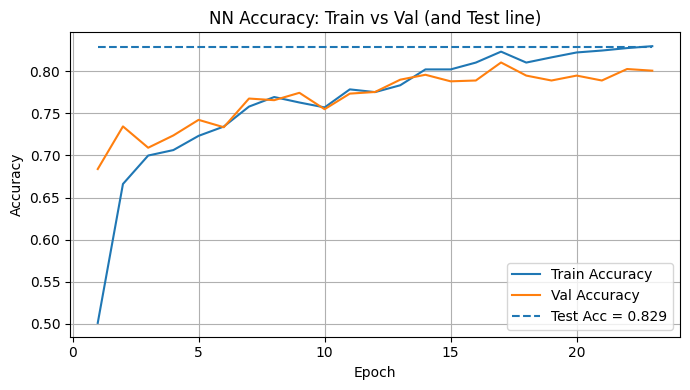

In [174]:
epochs = np.arange(1, len(history.history["accuracy"]) + 1)

plt.figure(figsize=(7, 4))
plt.plot(epochs, history.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="Val Accuracy")
plt.hlines(nn_test_acc, epochs[0], epochs[-1], linestyles="dashed", label=f"Test Acc = {nn_test_acc:.3f}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("NN Accuracy: Train vs Val (and Test line)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [175]:
# Feature extractor: outputs the learned text-tab embedding
text_tab_extractor = Model(
    inputs=text_tab_model.inputs,
    outputs=text_tab_model.get_layer("text_tab_embedding").output
)

Z_texttab_tr = text_tab_extractor.predict({"text_in": X_text_tr_pad, "tab_in": X_tab_tr_scaled}, batch_size=256, verbose=0)
Z_texttab_te = text_tab_extractor.predict({"text_in": X_text_te_pad, "tab_in": X_tab_te_scaled}, batch_size=256, verbose=0)
Z_texttab_val = text_tab_extractor.predict({"text_in": X_text_val_pad, "tab_in": X_tab_val_scaled}, batch_size=256, verbose=0)

print("Text-Tab embeddings:", Z_texttab_tr.shape, Z_texttab_te.shape, Z_texttab_val.shape)

Text-Tab embeddings: (3082, 128) (1028, 128) (1028, 128)


In [181]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [219]:
IMG_SIZE = 160
BATCH_SIZE = 32

def make_dataset_mobilenet(img_paths, labels, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, labels))

    def _load_image(path, label):
        img_bytes = tf.io.read_file(path)
        img = tf.image.decode_image(img_bytes, channels=3)
        img.set_shape([None, None, 3])
        if augment:
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, 0.15)
            img = tf.image.random_contrast(img, 0.8, 1.2)
            img = tf.image.random_saturation(img, 0.8, 1.2)
            img = tf.image.random_hue(img, 0.02)

        img = tf.cast(img, tf.float32)
        img = preprocess_input(img)

        return img, label

    ds = ds.map(_load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(img_paths), reshuffle_each_iteration=True)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


In [233]:
train_ds_mob = make_dataset_mobilenet(
    X_img_tr, y_tr, shuffle=True, augment=True
)

val_ds_mob = make_dataset_mobilenet(
    X_img_val, y_val, shuffle=False, augment=False
)

test_ds_mob = make_dataset_mobilenet(
    X_img_te, y_te, shuffle=False, augment=False
)


In [231]:
tf.keras.backend.clear_session()

In [232]:
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False


inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)


embedding = layers.Dense(128, activation="relu", name="img_embedding")(x)
embedding = layers.BatchNormalization()(embedding)
outputs = layers.Dense(num_classes, activation="softmax")(embedding)

mob_model = models.Model(inputs, outputs)

mob_model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

mob_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ img_embedding (Dense)           │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,109 (9.24 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [234]:

history_mob = mob_model.fit(
    train_ds_mob,
    validation_data=val_ds_mob,
    epochs=12,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=1, factor=0.5, min_lr=1e-6)
    ],
    verbose=1
)

Epoch 1/12
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.2304 - loss: 2.0965 - val_accuracy: 0.2665 - val_loss: 1.7288 - learning_rate: 5.0000e-05
Epoch 2/12
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.2524 - loss: 1.9969 - val_accuracy: 0.2821 - val_loss: 1.7116 - learning_rate: 5.0000e-05
Epoch 3/12
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.2713 - loss: 1.9044 - val_accuracy: 0.2967 - val_loss: 1.7009 - learning_rate: 5.0000e-05
Epoch 4/12
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.3008 - loss: 1.8122 - val_accuracy: 0.3045 - val_loss: 1.6875 - learning_rate: 5.0000e-05
Epoch 5/12
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 0.2992 - loss: 1.7947 - val_accuracy: 0.3181 - val_loss: 1.6628 - learning_rate: 5.0000e-05
Epoch 6/12
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.3118 - loss: 1.7526 - val_accuracy: 0.3171 - val_loss: 1.6435 - learning_rate: 5.0000e-05
Epoch 7/12
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - acc

In [235]:
test_loss, test_acc = mob_model.evaluate(test_ds_mob, verbose=0)
print("MobileNetV2 Test Accuracy:", test_acc)


MobileNetV2 Test Accuracy: 0.34241244196891785


In [236]:
feature_extractor_mob = tf.keras.Model(
    inputs=mob_model.input,
    outputs=mob_model.get_layer("img_embedding").output
)


In [237]:
Z_img_tr = feature_extractor_mob.predict(train_ds_mob, verbose=1)
Z_img_val = feature_extractor_mob.predict(val_ds_mob, verbose=1)
Z_img_te = feature_extractor_mob.predict(test_ds_mob, verbose=1)

print("Image embeddings shapes:")
print("Train:", Z_img_tr.shape)
print("Val:  ", Z_img_val.shape)
print("Test: ", Z_img_te.shape)


97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step
Image embeddings shapes:
Train: (3082, 128)
Val:   (1028, 128)
Test:  (1028, 128)


In [238]:
# ---- Fuse features ----
X_fused_tr  = np.hstack([Z_texttab_tr,  Z_img_tr])
X_fused_val = np.hstack([Z_texttab_val, Z_img_val])
X_fused_te  = np.hstack([Z_texttab_te,  Z_img_te])

print("Fused features:")
print("Train:", X_fused_tr.shape)
print("Val:  ", X_fused_val.shape)
print("Test: ", X_fused_te.shape)


Fused features:
Train: (3082, 256)
Val:   (1028, 256)
Test:  (1028, 256)


In [254]:


svm = LinearSVC(
    C=0.1,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

svm.fit(X_fused_tr, y_tr)


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,0.1
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,42


In [255]:
# -------- Linear SVM predictions --------
svm_train_pred = svm.predict(X_fused_tr)
svm_test_pred  = svm.predict(X_fused_te)

print("\n=== Linear SVM on fused features ===")
print(f"Train Accuracy: {accuracy_score(y_tr, svm_train_pred):.4f}")
print(f"Test  Accuracy: {accuracy_score(y_te, svm_test_pred):.4f}")

print("\nTest Macro-F1:", f1_score(y_te, svm_test_pred, average="macro"))
print(classification_report(y_te, svm_test_pred))



=== Linear SVM on fused features ===
Train Accuracy: 0.8975
Test  Accuracy: 0.8307

Test Macro-F1: 0.8285439209553627
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       193
           1       0.77      0.78      0.77       197
           2       0.83      0.78      0.80       210
           3       0.78      0.84      0.81       197
           4       0.93      0.90      0.92       231

    accuracy                           0.83      1028
   macro avg       0.83      0.83      0.83      1028
weighted avg       0.83      0.83      0.83      1028



In [305]:

xgb = XGBClassifier(
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.0001,
    subsample=0.7,
    colsample_bytree=0.6,
    reg_lambda=1,
    objective="multi:softprob",
    num_class=num_classes,
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb.fit(
    X_fused_tr,
    y_tr,
)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [304]:
xgb_train_pred = xgb.predict(X_fused_tr)
xgb_test_pred  = xgb.predict(X_fused_te)

print("\n=== XGBoost on fused features ===")
print(f"Train Accuracy: {accuracy_score(y_tr, xgb_train_pred):.4f}")
print(f"Test  Accuracy: {accuracy_score(y_te, xgb_test_pred):.4f}")

print("\nTest Macro-F1:", f1_score(y_te, xgb_test_pred, average="macro"))
print(classification_report(y_te, xgb_test_pred))



=== XGBoost on fused features ===
Train Accuracy: 0.8851
Test  Accuracy: 0.8307

Test Macro-F1: 0.8282120173109242
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       193
           1       0.75      0.78      0.76       197
           2       0.82      0.76      0.79       210
           3       0.80      0.84      0.82       197
           4       0.93      0.92      0.93       231

    accuracy                           0.83      1028
   macro avg       0.83      0.83      0.83      1028
weighted avg       0.83      0.83      0.83      1028



In [307]:
# ---- SVM accuracies ----
svm_train_acc = accuracy_score(y_tr, svm.predict(X_fused_tr))
svm_test_acc  = accuracy_score(y_te, svm.predict(X_fused_te))
# ---- XGBoost accuracies ----
xgb_train_acc = accuracy_score(y_tr, xgb.predict(X_fused_tr))
xgb_test_acc  = accuracy_score(y_te, xgb.predict(X_fused_te))



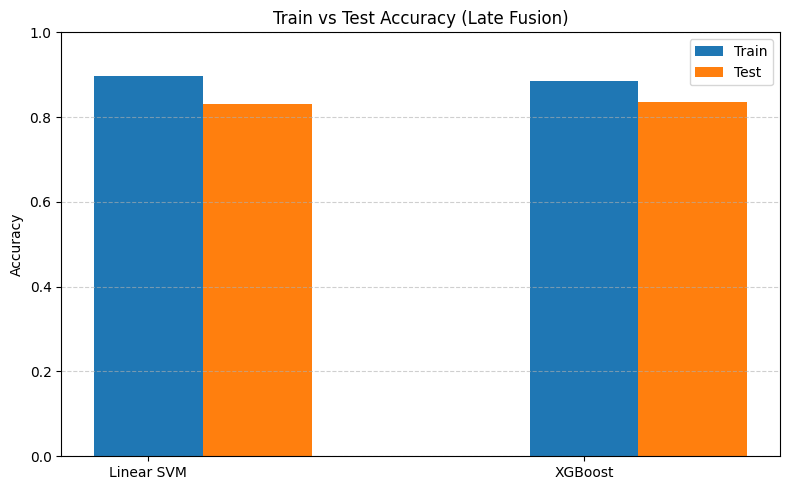

In [309]:
import matplotlib.pyplot as plt
import numpy as np

models = ["Linear SVM", "XGBoost"]
train_acc = [svm_train_acc, xgb_train_acc]
test_acc  = [svm_test_acc,  xgb_test_acc]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x , train_acc, width, label="Train")
plt.bar(x + width, test_acc,  width, label="Test")

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy (Late Fusion)")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
